In [ ]:
import numpy as np
import pandas as pd
import os
import string
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import losses
from keras import utils
from keras import Model
from keras.layers import LSTM, TextVectorization, Embedding, Dense, Bidirectional
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
tf.keras.utils.set_random_seed(42)

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


PART 1: DATA PREPROCESSING

In [ ]:
def remove_tags(sentence):
    """
    removes <e1>, </e1>, <e2>, and </e2> tags from a given sentence
    """
    tags = ['<e1>', '</e1>', '<e2>', '</e2>']
    for tag in tags:
        sentence = sentence.replace(tag, '')
    return sentence


def load_data(file_path):
    """
    loads the sentences and their corresponding labels from a file into a Pandas dataframe
    """
    # read the file and split the lines
    with open(file_path, 'r') as f:
        lines = f.read().splitlines()

    # split each line into the sentence and the label
    data = []
    for i in range(0, len(lines), 4):
        allowed = {'Cause-Effect': 1, 'Component-Whole': 2, 'Product-Producer': 3, 'Instrument-Agency': 4}
        sentence = remove_tags(lines[i].split('\t')[1])[1:-1]
        label = lines[i + 1]
        if label == 'Other' or label[:-7] not in allowed:
            data.append([sentence, 0.0, 0.0])
        else:
            direction = float(label[-7:][2])
            relation = label[:-7]
            data.append([sentence, direction, allowed[relation]])
    # create a dataframe from the data
    df = pd.DataFrame(data, columns=['sentence', 'direction', 'label'])
    return df

In [ ]:
train_path = os.path.join(os.getcwd(), 'drive', 'My Drive', 'cs6320', 'SemEval2010', 'train', 'TRAIN_FILE.TXT') 
train_df = load_data(train_path)
# rows_to_delete = train_df[train_df['label'] == 0].sample(n=4060).index
# train_df = train_df.drop(rows_to_delete)
train_df.head()

,sentence,direction,label
0,The system as described above has its greatest...,2.0,2.0
1,The child was carefully wrapped and bound into...,0.0,0.0
2,The author of a keygen uses a disassembler to ...,2.0,4.0
3,A misty ridge uprises from the surge.,0.0,0.0
4,The student association is the voice of the un...,0.0,0.0


In [ ]:
pd.concat([train_df['label'].value_counts(), 100 * train_df['label'].value_counts(normalize=True)], axis=1, keys=['count of relation', '%'])

,count of relation,%
0.0,4835,60.4375
1.0,1003,12.5375
2.0,941,11.7625
3.0,717,8.9625
4.0,504,6.3000


In [ ]:
test_path = os.path.join(os.getcwd(), 'drive', 'My Drive', 'cs6320', 'SemEval2010', 'test_keys', 'TEST_FILE_FULL.TXT') 
test_df = load_data(test_path)
test_df.head()

,sentence,direction,label
0,The most common audits were about waste and re...,0.0,0.0
1,The company fabricates plastic chairs.,2.0,3.0
2,The school master teaches the lesson with a st...,2.0,4.0
3,The suspect dumped the dead body into a local ...,0.0,0.0
4,Avian influenza is an infectious disease of bi...,2.0,1.0


In [ ]:
pd.concat([test_df['label'].value_counts(), 100 * train_df['label'].value_counts(normalize=True)], axis=1, keys=['count of relation', '%'])

,count of relation,%
0.0,1690,60.4375
1.0,328,12.5375
2.0,312,11.7625
3.0,231,8.9625
4.0,156,6.3000


In [ ]:
x_train = train_df['sentence']
y_train = train_df[['direction', 'label']]

PART 2: TRAIN A LSTM BASED MODEL ON THE TRAINING SET

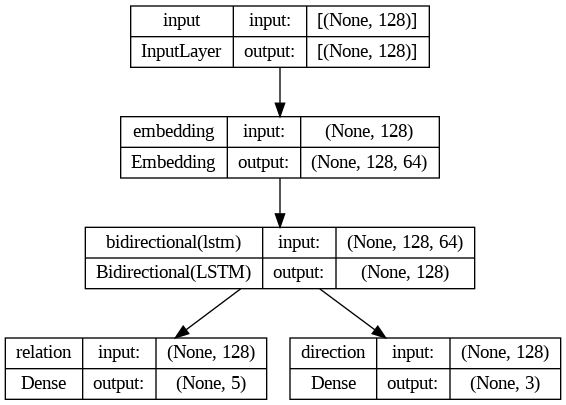

In [ ]:
MAX_SEQ_LEN = 128
VOCAB_SIZE = 25000
# tokenize the input
tokenizer = TextVectorization(max_tokens=VOCAB_SIZE, output_mode='int', output_sequence_length=MAX_SEQ_LEN)
tokenizer.adapt(train_df['sentence'].values)

# build the model
input = keras.Input(shape=(MAX_SEQ_LEN, ), name='input')
embedding = Embedding(VOCAB_SIZE, 64)(input)
lstm = Bidirectional(LSTM(64))(embedding)
relation_pred = Dense(5, activation='softmax', name='relation')(lstm)
direction_pred = Dense(3, activation='softmax', name='direction')(lstm)
model = keras.Model(inputs=[input], outputs=[relation_pred, direction_pred])

# show a diagram of the model
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.compile(
    optimizer=Adam(0.001), 
    loss={
        'relation': keras.losses.CategoricalCrossentropy(),
        'direction': keras.losses.CategoricalCrossentropy(),
    },
    loss_weights={'relation': 5.0, 'direction': 0.5}
)

In [ ]:
x_train_tokenized = tokenizer(x_train)
y_rel_train = pd.get_dummies(y_train['label'])
y_dir_train = pd.get_dummies(y_train['direction'])
model.fit(
    {'input': x_train_tokenized},
    {'relation': y_rel_train, 'direction': y_dir_train},
    epochs=20, 
    batch_size=8,
    validation_split=0.2
)

Epoch 1/20
800/800 [==============================] - 14s 12ms/step - loss: 5.2180 - relation_loss: 0.9652 - direction_loss: 0.7837 - val_loss: 6.0135 - val_relation_loss: 1.1151 - val_direction_loss: 0.8760
Epoch 2/20
800/800 [==============================] - 9s 11ms/step - loss: 2.7212 - relation_loss: 0.4965 - direction_loss: 0.4769 - val_loss: 6.7351 - val_relation_loss: 1.2456 - val_direction_loss: 1.0145
Epoch 3/20
800/800 [==============================] - 9s 11ms/step - loss: 1.1814 - relation_loss: 0.2037 - direction_loss: 0.3261 - val_loss: 7.8842 - val_relation_loss: 1.4537 - val_direction_loss: 1.2314
Epoch 4/20
800/800 [==============================] - 9s 11ms/step - loss: 0.4691 - relation_loss: 0.0660 - direction_loss: 0.2784 - val_loss: 10.6695 - val_relation_loss: 1.9679 - val_direction_loss: 1.6598
Epoch 5/20
800/800 [==============================] - 9s 11ms/step - loss: 0.2861 - relation_loss: 0.0312 - direction_loss: 0.2606 - val_loss: 10.3007 - val_relation_loss

In [ ]:
y_pred_rel, y_pred_dir = model.predict(tokenizer(train_df['sentence']))
y_pred_rel = np.argmax(y_pred_rel, axis=1)
y_pred_dir = np.argmax(y_pred_dir, axis=1)

acc_rel = accuracy_score(y_pred_rel, train_df['label'])
print('accuracy on the train set when considering only the relation = {:.2f}%'.format(100 * acc_rel))

y_pred = np.vstack([y_pred_rel, y_pred_dir]).T
y_true = train_df[['label', 'direction']].to_numpy()
accuracy = sum(np.array_equal(pred, actual) for pred, actual in zip(y_pred, y_true)) / len(y_pred)
print('accuracy on the train set when considering relation and direction = {:.2f}%'.format(100 * accuracy))

250/250 [==============================] - 2s 4ms/step
accuracy on the train set when considering only the relation = 91.79%
accuracy on the train set when considering relation and direction = 90.48%


PART 3: TEST THE TRAINED MODEL ON THE TEST SET

In [ ]:
y_pred_rel, y_pred_dir = model.predict(tokenizer(test_df['sentence']))
y_pred_rel = np.argmax(y_pred_rel, axis=1)
y_pred_dir = np.argmax(y_pred_dir, axis=1)

acc_rel = accuracy_score(y_pred_rel, test_df['label'])
print('accuracy on the test set when considering only the relation = {:.2f}%'.format(100 * acc_rel))

y_pred = np.vstack([y_pred_rel, y_pred_dir]).T
y_true = test_df[['label', 'direction']].to_numpy()
accuracy = sum(np.array_equal(pred, actual) for pred, actual in zip(y_pred, y_true)) / len(y_pred)
print('accuracy on the test set when considering relation and direction = {:.2f}%'.format(100 * accuracy))

85/85 [==============================] - 1s 4ms/step
accuracy on the test set when considering only the relation = 73.02%
accuracy on the test set when considering relation and direction = 65.92%


PART 4: ANALYSIS OF 50 MISCLASSIFIED SENTENCES

In [ ]:
idx_to_rel = {0: 'Other', 1: 'Cause-Effect', 2: 'Component-Whole', 3: 'Product-Producer', 4: 'Instrument-Agency'}
idx_to_dir = {0: '', 1:'e1e2', 2:'e2e1'}
count = 0
print('sentence number\tpredicted relation\ttrue relation\tsentence')
for i, (pred, actual) in enumerate(zip(y_pred, y_true)):
    if not np.array_equal(pred, actual):
        print('{}\t{}({})\t{}({})\t{}'.format(i + 8001, idx_to_rel[pred[0]], idx_to_dir[pred[1]], idx_to_rel[actual[0]], idx_to_dir[actual[1]], test_df['sentence'].iloc[i]))
        count += 1
        if count == 50:
            break

sentence number	predicted relation	true relation	sentence
8001	Product-Producer(e2e1)	Other()	The most common audits were about waste and recycling.
8003	Component-Whole(e2e1)	Instrument-Agency(e2e1)	The school master teaches the lesson with a stick.
8006	Other()	Component-Whole(e1e2)	The ear of the African elephant is significantly larger--measuring 183 cm by 114 cm in the bush elephant.
8007	Other()	Product-Producer(e1e2)	A child is told a lie for several years by their parents before he/she realizes that a Santa Claus does not exist.
8008	Instrument-Agency(e2e1)	Other()	Skype, a free software, allows a hookup of multiple computer users to join in an online conference call without incurring any telephone costs.
8009	Other()	Component-Whole(e1e2)	The disgusting scene was retaliation against her brother Philip who rents the room inside this apartment house on Lombard street.
8018	Other(e2e1)	Other()	An FTP server is an inexpensive and relatively simple to operate tool that works great 